# Fitting Saturation-based Simulation Data With Multi-Output
Can having multiple labels per data improve validation loss? 


In [1]:
from pathlib import Path
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.data import (
    generate_data_loaders,
    equidistance_detector_normalization,
    constant_detector_count_normalization,
    config_based_normalization
)
from inverse_modelling_tfo.data.intensity_interpolation import (
    interpolate_exp,
    get_interpolate_fit_params,
    exp_piecewise_affine,
)
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod, HoldOneOut, CVSplit, CombineMethods
from inverse_modelling_tfo.models.custom_models import (
    SplitChannelCNN,
    PerceptronReLU,
    PerceptronBN,
    PerceptronDO,
    PerceptronBD,
    FeatureResidualNetwork
)
from inverse_modelling_tfo.features.build_features import (
    FetalACFeatureBuilder,
    RowCombinationFeatureBuilder,
    TwoColumnOperationFeatureBuilder,
    FetalACbyDCFeatureBuilder,
    LogTransformFeatureBuilder,
    ConcatenateFeatureBuilder,
)
from inverse_modelling_tfo.features.data_transformations import (
    LongToWideIntensityTransformation,
    ToFittingParameterTransformation,
)
from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed
from pyflowdiagram import draw_process_flow

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# DATA_PATH = r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc3.pkl'

# DATA_PATH = (r"/home/rraiyan/personal_projects/tfo_inverse_modelling/inverse_modelling_tfo/tools/s_based_intensity_low_conc5.pkl")

DATA_PATH = r'/home/rraiyan/simulations/tfo_sim/data/compiled_intensity/dan_iccps_pencil.pkl'
CONFIG_PATH = Path(r'/home/rraiyan/simulations/tfo_sim/data/compiled_intensity/dan_iccps_pencil.json')


data = pd.read_pickle(DATA_PATH)
# Drop Thickness values which I did not calculate the close concnetration points
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns="Uterus Thickness")

# Interpolate intensity to remove noise
# data = interpolate_exp(data, weights=(1, 0.6), interpolation_function=exp_piecewise_affine, break_indices=[4, 12, 20])
# data['Intensity'] = data['Interpolated Intensity']
# data = data.drop(columns='Interpolated Intensity')


# Manual log(intensity) normalization
# data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log

data_transformer = LongToWideIntensityTransformation()
fitting_param_transformer = ToFittingParameterTransformation()

# fitting_params = fitting_param_transformer.transform(data)
data = data_transformer.transform(data)
labels = data_transformer.get_label_names()
intensity_columns = data_transformer.get_feature_names()

# Cleanup
data.dropna(inplace=True)

# Build Features

In [4]:
from inverse_modelling_tfo.features.build_features import TypePairing
pairing_type: TypePairing 
pairing_type = "perm_r"     # type: ignore # permutation with replacement

### Grouping
Which rows of Fetal Hb conc should paired together is determined by this 'FconcCenters' column. For rows that should go together, this column should have the same value(id/ eg: 0, 1, 2, 3, ...)

In [5]:
# ROUNDING = 3
# fetal_conc_group_mapping = {
#     0.110 : 0,
#     0.115 : 0, 
#     0.100 : 0,
#     0.125 : 1,
#     0.130 : 1,
#     0.145 : 1,
#     0.155 : 2,
#     0.160 : 2,
#     0.170 : 2
# }

# data['FconcCenters'] = data['Fetal Hb Concentration'].round(ROUNDING).map(fetal_conc_group_mapping)    
# fitting_params['FconcCenters'] = data['FconcCenters']

In [6]:
# ROUNDING = 2
# fetal_conc_group_mapping = {
#     10.45 : 0,
#     11.00: 0, 
#     11.40: 0,
#     11.55: 1,
#     12.00: 1,
#     12.35: 1,
#     12.60: 2,
#     13.00: 2,
#     13.30: 2,
#     13.65: 3,
#     14.00: 3,
#     14.25: 3,
#     14.70: 4,
#     15.00: 4,
#     15.75: 4,
# }

# data['FconcCenters'] = data['Fetal Hb Concentration'].round(ROUNDING).map(fetal_conc_group_mapping)
# fitting_params['FconcCenters'] = data['FconcCenters']

In [7]:
fetal_conc_group_mapping = {
    10.45 : 0,
    10.88 : 0,
    11. : 0,
    11.31: 1,
    11.45: 1,
    11.55: 1,
    11.75: 2,
    11.91: 2,
    12.03: 2,
    12.18: 3,
    12.36: 3,
    12.5: 3,
    12.61: 4,
    12.82: 4,
    12.98: 4,
    13.04: 5,
    13.27: 5,
    13.46: 5,
    13.47: 6,
    13.73: 6,
    13.9: 6,
    13.94: 7,
    14.18: 7,
    14.34: 7,
    14.41: 8,
    14.64: 8,
    14.77: 8,
    14.89: 9,
    15.09: 9,
    15.2: 9,
    15.37: 10,
    15.55: 10,
    15.85: 10,
    16.: 11,
    16.32: 11,
    16.8: 11, 
}
data['FconcCenters'] = data['Fetal Hb Concentration'].round(2).map(fetal_conc_group_mapping)
# fitting_params['FconcCenters'] = data['FconcCenters']

## Fetal AC by DC Feature

In [8]:
fb1 = FetalACbyDCFeatureBuilder('FconcCenters', pairing_type, intensity_columns, labels, "max")
# feature_builder2 = TwoColumnOperationFeatureBuilder(x_columns1[len(x_columns1)//2:], x_columns1[:len(x_columns1)//2], "/", False, x_columns1, feature_builder1.get_label_names())

## Row Combination Spatial Intensity (or their Log)

In [9]:
fixed_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Saturation", "FconcCenters"]
fb3 = RowCombinationFeatureBuilder(intensity_columns, fixed_columns, ["Fetal Hb Concentration"], pairing_type, 2)
# feature_builder4 = LogTransformFeatureBuilder(feature_builder3.get_feature_names(), feature_builder3.get_feature_names(), feature_builder3.get_label_names())

## Fetal AC_wv1 by AC_wv2 Feature Builder

In [10]:
fb5 = FetalACFeatureBuilder('FconcCenters', pairing_type, '/', intensity_columns, labels)
x_columns5 = fb5.get_feature_names()
fb6 = TwoColumnOperationFeatureBuilder.from_chain(fb5, x_columns5[len(x_columns5)//2:], x_columns5[:len(x_columns5)//2], "/", False)

## Fitting Parameters

In [11]:
# fb0 = RowCombinationFeatureBuilder(fitting_param_transformer.get_feature_names(), fixed_columns, ["Fetal Hb Concentration"], pairing_type, 2)
# x_columns0 = fb0.get_feature_names()   
# fb7 = TwoColumnOperationFeatureBuilder.from_chain(fb0, x_columns0[:len(x_columns0)//2], x_columns0[len(x_columns0)//2:], '*', True)
# data1 = fb7(fitting_params)

## Combining Them Together

In [12]:
# fb_concat = ConcatenateFeatureBuilder([fb1, fb3, fb6])
# fb_concat = ConcatenateFeatureBuilder([fb3, fb6])
# data = fb_concat(data)

data = fb1(data)
print(len(data))

1492992


In [13]:
# data = pd.concat([data1[labels], data1[feature_builder2.get_fea`ture_names()], data2[feature_builder4.get_feature_names()]], axis=1)
# data = pd.concat([data1[fb1.get_label_names()], data1[fb1.get_feature_names()], data2[fb3.get_feature_names()], data3[fb5.get_feature_names()], data4[fb7.get_feature_names()]], axis=1)
# labels = fb_concat.get_label_names()
labels = fb1.get_label_names()
# data = pd.merge(data1, data2, on=labels, how='inner')
# labels = fb3.get_label_names()

In [14]:
# Define the input & output parameters to the NN
# x_columns = fb_concat.get_feature_names() + fb7.get_feature_names()
# x_columns = fb_concat.get_feature_names()
x_columns = fb1.get_feature_names()
# x_columns = fb7.get_feature_names()  + fb_concat.get_feature_names()[::2]
# x_columns = fb3.get_feature_names()
# y_columns = fb_concat.get_label_names()
# y_columns = fb3.get_label_names()
y_columns = fb1.get_label_names()

In [15]:
# Replace with ConcDiff
data["ConcDiff"] = data["Fetal Hb Concentration 1"] - data["Fetal Hb Concentration 0"]
if "ConcDiff" not in y_columns:
    y_columns.append("ConcDiff")

if "Fetal Hb Concentration 1" in y_columns:
    y_columns.remove("Fetal Hb Concentration 1")

if "Fetal Hb Concentration 0" in y_columns:
    y_columns.remove("Fetal Hb Concentration 0")

if "FconcCenters" in y_columns:
    y_columns.remove("FconcCenters")
print(y_columns)

['Maternal Wall Thickness', 'Maternal Hb Concentration', 'Maternal Saturation', 'Fetal Saturation', 'ConcDiff']


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [16]:
## X -> Predictors
# TODO: Maybe return these columns from the build_feature functions? have a single source of truth
# ratio_columns = list(filter(lambda X: X.isdigit(), data.columns))   # Can be empty 
# intensity_columns = list(filter(lambda X: '_' in X, data.columns))  # Can be empty 
# x_columns = ratio_columns + intensity_columns

## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]
# x_columns = list(filter(lambda X: 'alpha' in X, data.columns))

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

# Custom Loss Definition

In [17]:
class WeightedMSE(nn.Module):
    """
    MSE Loss for vector output labels with custom weighting
    """
    def __init__(self, loss_weights: torch.Tensor) -> None:
        super().__init__()
        # Reshape to row vector for broadcasting during loss calculation
        self.loss_weights = loss_weights.reshape(1, -1)
        self.mse_loss = nn.MSELoss(reduction='none')

    
    def forward(self, predicted_tmps, targets):
        loss = self.mse_loss(predicted_tmps, targets)
        loss = loss * self.loss_weights
        return loss.sum() / self.loss_weights.sum()

## Model Configuration

In [18]:
print("In Features :", len(x_columns))  
print("Out Features:", len(y_columns))

In Features : 40
Out Features: 5


# Setting up Special Residual Network 

In [19]:
# saturation_unique_values = data["Fetal Saturation"].unique()
# mean_saturation_level = saturation_unique_values[len(saturation_unique_values)//2]
# # Convert to float tensor, by default it is double
# lookup_table = torch.from_numpy(data[data["Fetal Saturation"] == mean_saturation_level].values).cuda().float()
# feature_indices = [data.columns.get_loc(feature) for feature in x_columns]
# feature_indices = torch.tensor(feature_indices).cuda()
# intermediate_labels = y_columns.copy()
# intermediate_labels.remove("Fetal Saturation")
# intermediate_label_indices = [data.columns.get_loc(label) for label in intermediate_labels]
# intermediate_labels = torch.tensor(intermediate_label_indices).cuda()

# # y_columns = ["Fetal Saturation"]

# feature_res_net_params = {
#         'node_count_left': [len(x_columns), 5, len(intermediate_labels)],
#         'dropout_rates_left': [0.5, 0.5],
#         'node_count_right': [len(x_columns), 5, len(y_columns)],
#         'dropout_rates_right': [0.5, 0.5],
#         'lookup_table': lookup_table,
#         'lookup_key_indices': intermediate_labels,
#         'feature_indices': feature_indices,
# }


In [35]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from inverse_modelling_tfo.models.train_model import ModelTrainerFactory
datagen_kw = {
    'table' : data,
    'data_loader_params' : 
        {
            'batch_size': 256, 'shuffle': True
        }, 
    'x_columns': x_columns,
    'y_columns': y_columns,
    'validation_method' : HoldOneOut('Maternal Wall Thickness', data['Maternal Wall Thickness'].unique()[3])
    # 'validation_method' : CombineMethods([
        # HoldOneOut('Maternal Wall Thickness', data['Maternal Wall Thickness'].unique()[3]), RandomSplit(0.9)])
    # 'validation_method' : HoldOneOut('Maternal Hb Concentration', 13.0)
    # 'validation_method' : HoldOneOut('Maternal Saturation', 1.0)
}

# criterion = WeightedMSE(torch.Tensor([1.0, 1.0, 1.0,  1.2, 1.0, 1.0]).cuda())
# criterion = WeightedMSE(torch.Tensor([4.0, 1.0, 1.0, 1.0, 1.0, 1.0]).cuda())
criterion = nn.MSELoss()
# criterion = nn.HuberLoss()
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 40, 20, 10, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 25, 12, 8, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 10, 10, 5, 5, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 20, 10, 5, 5, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(FeatureResidualNetwork, feature_res_net_params, generate_data_loaders, datagen_kw, 100, criterion)

## Hyper Parameter Tuning

In [36]:
# # Custom Train Function 
# def train_with_tuning(iteration_config):
#     set_seed(42)
#     trainer_tuning = trainer_factory.create()
#     trainer_tuning.reporting = True     # Report at each epoch to Ray Tune
#     if 'batch_size' in iteration_config:
#         trainer_tuning.change_batch_size(iteration_config['batch_size'])    # If batch_size needs tuning
#     trainer_tuning.set_optimizer(SGD, {'lr': iteration_config["lr"], 'momentum': iteration_config["momentum"]})
#     trainer_tuning.run()

In [37]:
# # Hyper Parameter Search 
# iteration_config = {
#     "lr" : tune.loguniform(1e-4, 1e-2),
#     # "lr" : tune.loguniform(1e-7, 1e-4), # Need smaller learning rates when using weighted multi-headed outputs
#     "momentum": tune.uniform(0.9, 0.99),
# }
# scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=60, grace_period=5, reduction_factor=2)
# reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"],
#                        parameter_columns=["lr", "momentum"])
# result = tune.run(train_with_tuning, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
#                   num_samples=80, resources_per_trial={"cpu": 0, "gpu": 0.2},)

# # Get the trial with the best validation loss 
# best_trial = result.get_best_trial("val_loss", "min", "last")
# print("Best trial config: {}".format(best_trial.config))
# print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
# print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))


<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [38]:
# best_trial.config

## Custom Training

In [39]:
set_seed(42)
trainer = trainer_factory.create()
trainer.set_optimizer(SGD, {'lr': 3e-4, 'momentum': 0.948, 'weight_decay': 1e-4})
# trainer.change_batch_size(2048)
trainer.change_batch_size(252)
trainer.epochs = 30
trainer.run()

# trainer.epochs = 30
# trainer.run() 

In [40]:
# trainer.change_batch_size(64)
# trainer.epochs = 20
# trainer.change_batch_size(2048)
# trainer.epochs = 50
# trainer.run()

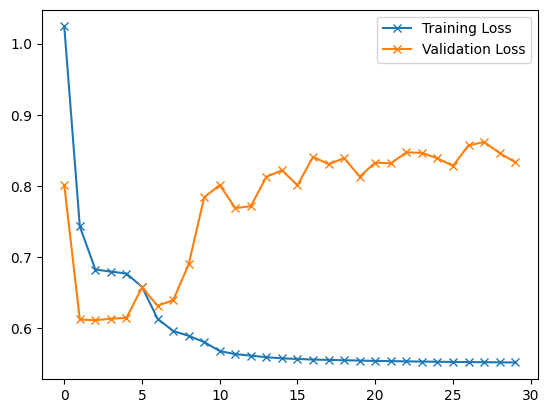

In [41]:
plt.figure()
plt.plot(trainer.train_loss, label='Training Loss', marker='x')
plt.plot(trainer.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [42]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=40, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.5, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=5, bias=True)
    (9): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout1d(p=0.5, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=5, out_features=5, bias=True)
    (13): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout1d(p=0.5, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=5, out_features=5, bias=True)
    (17): Flatten(start_dim=1, end_dim=-1)
 

In [43]:
train_error, train_pred = generate_model_error_and_prediction(trainer.model, trainer.train_loader, y_columns, y_scaler)
val_error, val_pred = generate_model_error_and_prediction(trainer.model, trainer.validation_loader, y_columns, y_scaler)

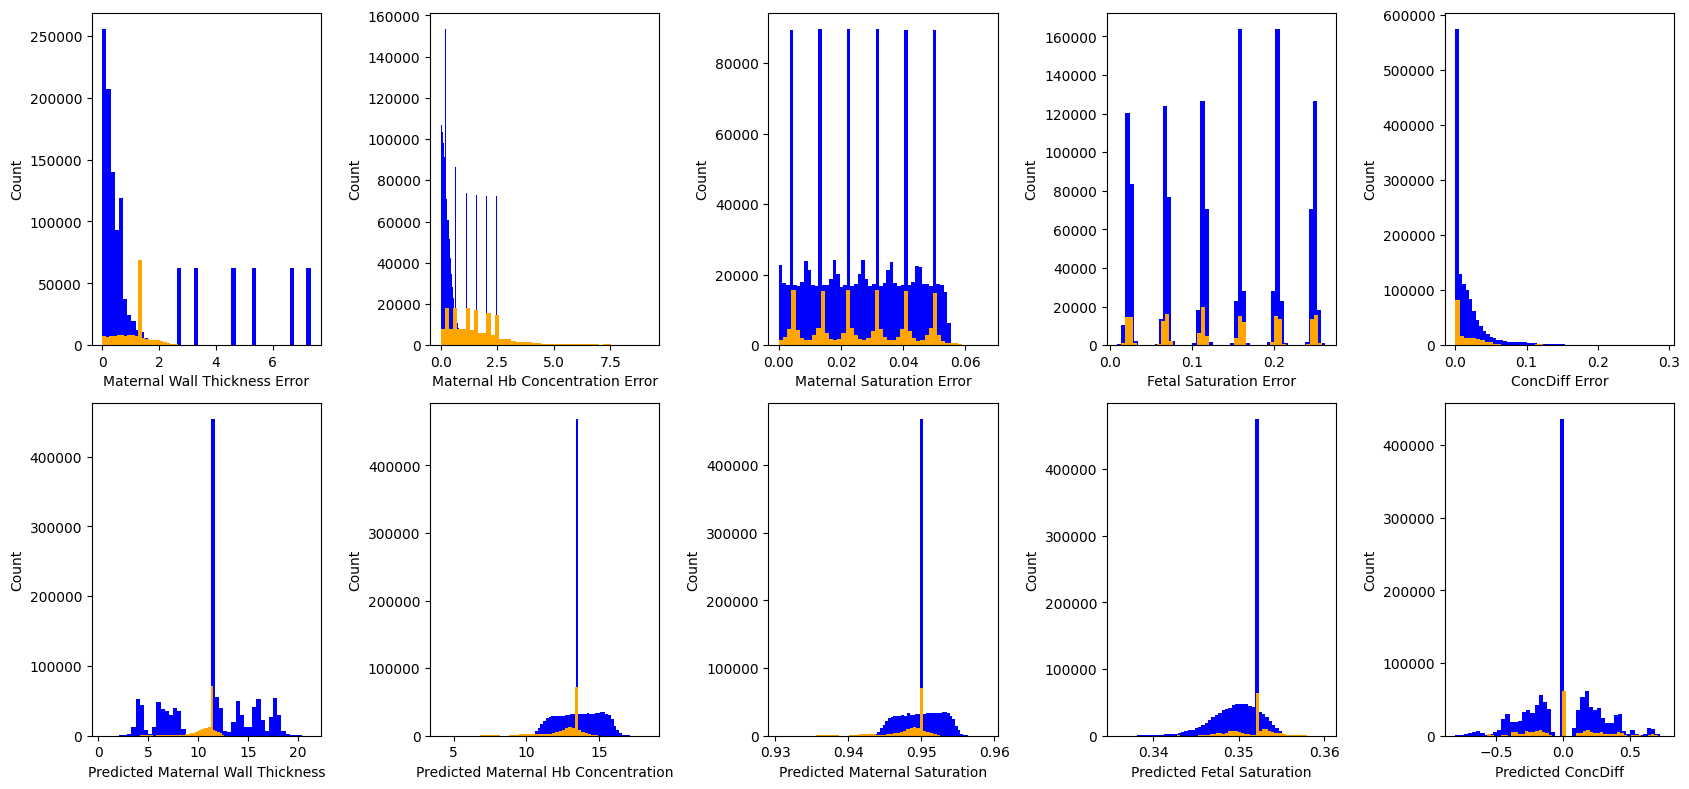

In [44]:
fig, axes = plt.subplots(2, len(y_columns), squeeze=True, figsize=(17, 8))
BIN_COUNT = 50
for i in range(len(y_columns)):
    # Plot Errors
    ax = axes[0, i]
    plt.sca(ax)
    column_name = train_error.columns[i]
    plt.hist(train_error[column_name], bins=BIN_COUNT, color='blue')
    plt.hist(val_error[column_name], bins=BIN_COUNT, color='orange')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    
    # Plot Predictions
    ax = axes[1, i]
    plt.sca(ax)
    column_name = train_pred.columns[i]
    plt.hist(train_pred[column_name], bins=BIN_COUNT, color='blue')
    plt.hist(val_pred[column_name], bins=BIN_COUNT, color='orange')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    
plt.tight_layout()
plt.show()

In [45]:
# # Top Bad Samples
# VIEW_TOP_N = 50
# worst_errors = error_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]  # Worst Results
# # worst_errors = error_df['Absolute Error'].argsort()[:VIEW_TOP_N]  # Best Results
# combined_table = data.join(error_df)
# with pd.option_context("display.max_rows", None):
#     display(combined_table[['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation", 'Truth', 'Predicted', 'Absolute Error', '%tage']].iloc[worst_errors, :])

In [46]:
# # Rough MSE's in percentage
# print(f'Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }')
# print(f'Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }')

In [47]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       820
│    └─BatchNorm1d: 2-2                  40
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       210
│    └─BatchNorm1d: 2-6                  20
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       55
│    └─BatchNorm1d: 2-10                 10
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      30
│    └─BatchNorm1d: 2-14                 10
│    └─Dropout1d: 2-15                   --
│    └─ReLU: 2-16                        --
│    └─Linear: 2-17                      30
│    └─Flatten: 2-18                     --
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0

In [48]:
# model_name = 'msat_percep_irsi'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')

In [49]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')